In [1]:
import pandas as pd
import polars as pl
import numpy as np
import mlflow
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt

# Считываем все нужные данные
В этом блоке я модифицировал стартовый ноутбук с оригинального контеста

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [61]:
train_basetable = pl.read_parquet("parquet_files/train_base_table.parquet")
test_basetable = pl.read_parquet("parquet_files/test_base_table.parquet")

static = pl.concat(
    [
        pl.read_parquet("parquet_files/train/train_static_0_0.parquet").pipe(set_table_dtypes),
        pl.read_parquet("parquet_files/train/train_static_0_1.parquet").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
static_cb = pl.read_parquet("parquet_files/train/train_static_cb_0.parquet").pipe(set_table_dtypes)
person_1 = pl.read_parquet("parquet_files/train/train_person_1.parquet").pipe(set_table_dtypes) 
credit_bureau_b_2 = pl.read_parquet("parquet_files/train/train_credit_bureau_b_2.parquet").pipe(set_table_dtypes) 

На этом моменте мне хочется остановится подольше, чтобы разобраться, что я хочу аргрегировать, а что нет, и как это лучше сделать. Но уже понимаю, что я хочу сохранить все признаки нулевой глубины, как минимимум. Давайте я подробнее окунусь в описание датасета.


In [9]:
feature_definition = pd.read_csv('feature_definitions.csv')
feature_definition.head(2)

,Variable,Description
0,actualdpd_943P,Days Past Due (DPD) of previous contract (actu...
1,actualdpdtolerance_344P,DPD of client with tolerance.


Начнём наше исследование с ключевой таблици о человеке (да, я реально буду это всё читать)

In [10]:
feature_definition[feature_definition['Variable'].isin(person_1.columns)]

,Variable,Description
40,birth_259D,Date of birth of the person.
42,birthdate_87D,Birth date of the person.
47,childnum_185L,Number of children of the applicant.
77,contaddr_district_15M,Zip code of a contact person's address.
78,contaddr_matchlist_1032L,Indicates whether the contact address is found...
79,contaddr_smempladdr_334L,Indicates whether the contact address is the s...
80,contaddr_zipcode_807M,Zip code of contact address.
162,education_927M,Education level of the person.
164,empl_employedfrom_271D,Start date of employment.
165,empl_employedtotal_800L,Employment length of a person.


In [11]:
person_selected_cols = ['birth_259D', 'childnum_185L', 'education_927M', 'empl_employedtotal_800L',
                        'familystate_447L', 'gender_992L', 'sex_738L', 'housetype_905L', 'housingtype_772L',
                        'isreference_387L', 'incometype_1044T', 'mainoccupationinc_384A', 'maritalst_703L',
                        'persontype_1072L', 'persontype_792L', 'safeguarantyflag_411L', 'num_group1']

In [12]:
person_1_grouped = person_1.group_by("case_id").agg(
    pl.col('birth_259D').first().str.slice(0, 4).str.to_integer().alias("my_birth_yearD"),
    pl.col('childnum_185L').filter(pl.col('childnum_185L').is_not_null()).last().alias('my_childnum_ltL'),
    pl.col('education_927M').filter(pl.col('education_927M').is_not_null()).last().alias('my_educ_ltM'),
    pl.col('familystate_447L').filter(pl.col('familystate_447L').is_not_null()).last().alias('my_fmlyState_ltL'),
    pl.col('gender_992L').filter(pl.col('gender_992L').is_not_null()).first().alias('my_sexL'),
    pl.col('housetype_905L').filter(pl.col('housetype_905L').is_not_null()).first().alias('my_houstype_ftL'),
    pl.col('isreference_387L').any().alias('my_referL'),
    pl.col('incometype_1044T').filter(pl.col('incometype_1044T').is_not_null()).last().alias('my_incometype_ltT'),
    pl.col("mainoccupationinc_384A").max().alias("my_mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("my_mainoccupationinc_384A_any_selfemployed"),
    pl.col('maritalst_703L').filter(pl.col('maritalst_703L').is_not_null()).last().alias('my_MaritalStatus_ltL'),
    pl.col('persontype_1072L').filter(pl.col('persontype_1072L').is_not_null()).last().alias('my_personType_ltL'),
    pl.col('persontype_792L').filter(pl.col('persontype_792L').is_not_null()).last().alias('my_personType2_ltL'),
    pl.col('safeguarantyflag_411L').any().alias('my_flexL'),
    pl.col('num_group1').count().alias('my_num_group1_countM')
)

In [13]:
credit_bureau_b_2_feats = credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("my_pmts_pmtsoverdue_635A_max"),
    pl.col("pmts_dpdvalue_108P").mean().alias("my_pmts_dpdvalue_108P_over31"),
)

In [14]:
feature_definition[feature_definition['Variable'].isin(static.columns)].shape

(167, 2)

In [15]:
feature_definition[feature_definition['Variable'].isin(static_cb.columns)].shape

(52, 2)

Как можно увидеть, количество колонок тут зашкаливает, и вручную их все отсматривать не вариант. Но давайте пока что попробуем добавить все признаки как есть, а в конце выкинем лишние

In [58]:
def data_join(basetable):
    df = basetable.join(
        static, how="left", on="case_id"
    ).join(
        static_cb, how="left", on="case_id"
    ).join(
        person_1_grouped, how="left", on="case_id"
    ).join(
        credit_bureau_b_2_feats, how="left", on="case_id"
    )

    return df

train_data = data_join(train_basetable)
test_data = data_join(test_basetable)

In [51]:
# для простоты создадим список колонок, на которых будет обучение
cols_pred = []
for col in train_data.columns:
    if col != 'target' and col != 'WEEK_NUM':
        cols_pred.append(col)

In [60]:
# перейдём в мир панд
train = convert_strings(train_data.to_pandas()).drop('WEEK_NUM', axis=1)
test = convert_strings(test_data.to_pandas()).drop('WEEK_NUM', axis=1)

In [61]:
print(f'train shape {train.shape}\n',
      f'train_basetable shape {train_basetable.shape}\n',
      f'test shape {test.shape}\n',
      f'test_basetable shape {test_basetable.shape}')

train shape (1219149, 240)
 train_basetable shape (1219149, 5)
 test shape (307510, 239)
 test_basetable shape (307510, 4)


# Эксперимент №1
Проверим, как к этому моменту у нас справляется модель

In [8]:
!mlflow server --host 127.0.0.1 --port 5000

^C


http://127.0.0.1:5000

In [21]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("the initial experiment")

<Experiment: artifact_location='mlflow-artifacts:/658858294007354946', creation_time=1712775977854, experiment_id='658858294007354946', last_update_time=1712775977854, lifecycle_stage='active', name='the initial experiment', tags={}>

In [22]:
start_exp = mlflow.get_experiment_by_name('the initial experiment')

In [23]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('target', axis=1), train['target'],
                                                  test_size= 0.25, random_state=42)

In [24]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000,
    "verbose": -1,
}

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(50), lgb.early_stopping(10)]
)

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[50]	valid_0's auc: 0.771032
[100]	valid_0's auc: 0.789649
[150]	valid_0's auc: 0.796465
[200]	valid_0's auc: 0.801036
[250]	valid_0's auc: 0.804055
[300]	valid_0's auc: 0.806535
[350]	valid_0's auc: 0.808489
[400]	valid_0's auc: 0.809844
[450]	valid_0's auc: 0.810933
[500]	valid_0's auc: 0.81171
[550]	valid_0's auc: 0.812409
[600]	valid_0's auc: 0.813232
[650]	valid_0's auc: 0.813777
[700]	valid_0's auc: 0.814196
[750]	valid_0's auc: 0.814946
[800]	valid_0's auc: 0.815532
[850]	valid_0's auc: 0.815994
[900]	valid_0's auc: 0.816254
[950]	valid_0's auc: 0.816739
[1000]	valid_0's auc: 0.816921
Did not meet early stopping. Best iteration is:
[1000]	valid_0's auc: 0.816921


Как мы можем увидеть, наша модель уже побивает первый бейслайн, и уже очень близко подбирается ко второму

Посмотрим, какой вклад дала каждая из фитчей

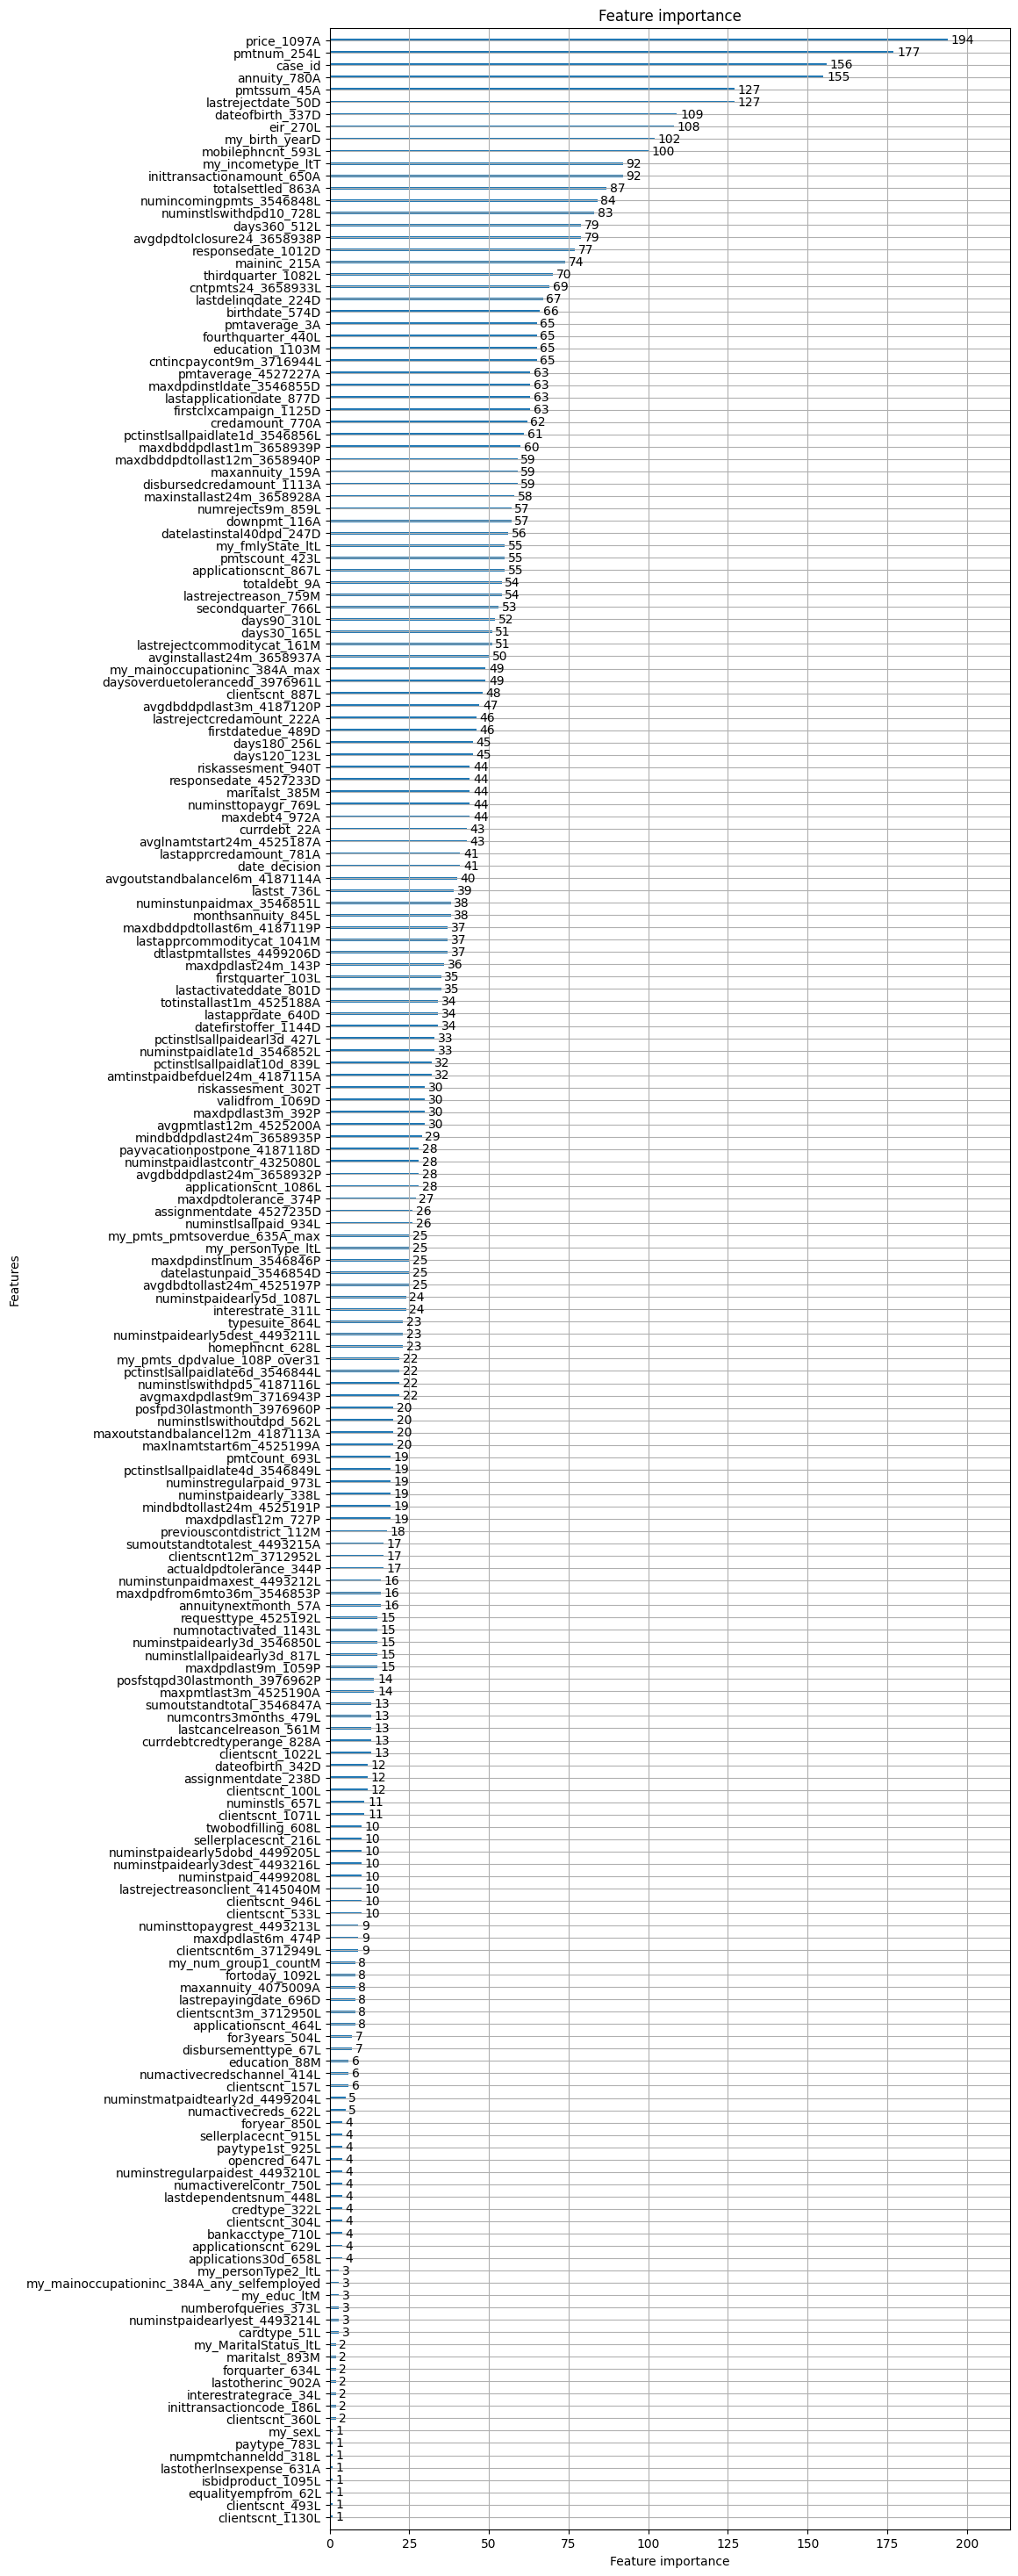

In [25]:
lgb.plot_importance(gbm, figsize=(10, 37))
plt.savefig(f"feature_importance_{start_exp._name}.pdf", format='pdf') 

Как можно заметить, есть переобучение (признак `case_id` попал в топ 3 признаков). Многие признаки не дают ничего, и что удивительно, пол человека не решает... Мои игрегриррованные данные не сильно хорошо правились.

Давайте залогируем

In [11]:
def mlflow_logging(train, models, models_name, acur, exp, i):
    with mlflow.start_run(run_name=f'Run {i}', experiment_id=exp.experiment_id) as run:
        mlflow.log_param('shape of train dataset', train.shape)

        for k, model in enumerate(models):
            mlflow.log_params(model.params)
            mlflow.log_param('model_type', f'{models_name[k]}')

        mlflow.log_metric('roc auc score', acur)

        cols_pred = []
        for col in train.columns:
            if col != 'target':
                cols_pred.append(col)
                
        importance = pd.DataFrame({
            "feature" : cols_pred,
            'importance' : gbm.feature_importance()
        })
        importance.sort_values('importance', ascending=False, inplace=True)
        importance.to_csv(f'importance of {exp.name} {i}.csv', index=False)
        
        #mlflow.log_artifact('feature_importance_the initial experiment.jpg')
        mlflow.log_artifact(f'importance of {exp.name} {i}.csv')
        mlflow.lightgbm.log_model(gbm, 'lgbm')

In [ ]:
mlflow_logging(train, gbm, start_exp, 1)

In [64]:
# Теперь сохраним получившийся эксперемент в отдельный датасет
train.to_csv('train_exp1.csv', index=False)
test.to_csv('test_exp1.csv', index=False)

# Эксперимент №2
В этом разделе я хочу избавиться от ненужных признаков. Кроме того, я хочу добавить признаки из других таблиц, но сделать это с умом. В этом мне должен помочь mlflow, ведь судя по названию в него полезно подавать поток моделей.

Я полагаю, что если я добавлю все таблицы сразу со всеми колонками, то всё взорвётся от количества данных. Да, `LightGMB` адаптирован для масштабирования, но обучаться на мусоре я не хочу. Поэтому я не буду сразу соединять все таблицы в одну большую и учиться на ней, а буду по отдельности добавлять агрегиррованные данные, выделять из них самые полезные и только их оставлять. Этот подход жадный, но это даже лучше, т.к. мы не будем видеть какие-то слишком сложные зависимости.

Кроме того, я ж ведь хочу стать разработчиком машинного обучения, а как полагается разработчику, я автоматизирую агрегацию признаков в таблицах. 

In [5]:
train = pl.read_csv('train_exp1.csv')
test = pl.read_csv('test_exp1.csv')
feature_imp_exp1 = pl.read_csv('importance of the initial experiment 1.csv')
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Exp2")

<Experiment: artifact_location='mlflow-artifacts:/651745909881068576', creation_time=1712865292578, experiment_id='651745909881068576', last_update_time=1712865292578, lifecycle_stage='active', name='Exp2', tags={}>

In [35]:
# избавимся от признаков, которые дают малый вклад в предсказание (моей обработке)
# кроме того, мой компьютер просто не может переваривать большие датасеты
useless_feature = feature_imp_exp1.filter(pl.col('importance') <= 10).select('feature').to_series().to_list()
usefull_feature = feature_imp_exp1.filter(pl.col('importance') > 10).select('feature').to_series().to_list()

In [6]:
exp = mlflow.get_experiment_by_name('Exp2')

In [7]:
applprev = pl.concat(
    [
        pl.read_parquet("parquet_files/train/train_applprev_1_0.parquet").pipe(set_table_dtypes),
        pl.read_parquet("parquet_files/train/train_applprev_1_0.parquet").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)

# ТАК ДЕЛАТЬ НЕ НАДО, У МЕНЯ КРАШИТСЯ НОУТБУК ДАЖЕ С ПАРКЕТОМ
# credit_bureau_a_1 = pl.concat(
#     [
#         pl.read_parquet("parquet_files/train/train_credit_bureau_a_1_0.parquet").pipe(set_table_dtypes),
#         pl.read_parquet("parquet_files/train/train_credit_bureau_a_1_1.parquet").pipe(set_table_dtypes),
#         pl.read_parquet("parquet_files/train/train_credit_bureau_a_1_2.parquet").pipe(set_table_dtypes),
#         pl.read_parquet("parquet_files/train/train_credit_bureau_a_1_3.parquet").pipe(set_table_dtypes),
#     ],
#     how="vertical_relaxed",
# )

deposit = pl.read_parquet("parquet_files/train/train_deposit_1.parquet").pipe(set_table_dtypes)
debitcard = pl.read_parquet("parquet_files/train/train_debitcard_1.parquet").pipe(set_table_dtypes)

In [31]:
new_tables = [applprev,
             # credit_bureau_a_1, 
              deposit, 
              debitcard]
new_tables_name = ['applprev',
                    # 'credit_bureau_a_1', 
                    'deposit', 
                    'debitcard']


params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": -1,
    "learning_rate": 0.1,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 700,
    "verbose": -1,
    "is_unbalance": True
}

def preprocess_2(df_orig, agr_tables, agr_names, exp, drop_cols=['case_id'], test_flag=False):
    for i, table in enumerate(agr_tables):
        df = df_orig.clone()
        print(f'Начал обработку {agr_names[i]}')
        tmp_table = pl.DataFrame()
        for cl in table.columns:
            if cl[-1] in ("P", "A"):
                tmp_table = tmp_table.with_columns(table.group_by("case_id").agg(
                    pl.col(cl).max().alias('my_' + cl)
                    )
                )
            elif cl[-1] in ('L', 'M'):
                tmp_table = tmp_table.with_columns(table.group_by("case_id").agg(
                    pl.col(cl).filter(pl.col(cl).is_not_null()).last().alias('my_' + cl)
                    )
                )
            elif cl[-1] == 'D':
                tmp_table = tmp_table.with_columns(table.group_by("case_id").agg(
                    pl.col(cl).filter(pl.col(cl).is_not_null()).str.slice(0, 4).str.to_integer().mean().alias('my_' + cl)
                    )
                )

        
        print(f'Аргрегировал {tmp_table.shape[1]} колонок из {agr_names[i]}')
        df = df.join(tmp_table, how="left", on='case_id')
        df = convert_strings(df.to_pandas()).drop(drop_cols, axis=1)
    
        X_train, X_val, y_train, y_val = train_test_split(df.drop('target', axis=1), df['target'],
                                                    test_size= 0.25, random_state=42)

        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

        model = lgb.train(
            params,
            lgb_train,
            valid_sets=lgb_valid,
            callbacks=[lgb.log_evaluation(500), lgb.early_stopping(10)]
        )

        mlflow_logging(df, model, exp, i)
    

In [36]:
preprocess_2(train, new_tables, new_tables_name, exp, drop_cols=useless_feature)

Начал обработку applprev
Аргрегировал 40 колонок из applprev


c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[208]	valid_0's auc: 0.809521
Начал обработку deposit
Аргрегировал 4 колонок из deposit


c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[228]	valid_0's auc: 0.81178
Начал обработку debitcard
Аргрегировал 5 колонок из debitcard


c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[258]	valid_0's auc: 0.81303


Посмотрим, какие результаты мы получили и сравним их с тем, что мы получим, если сделаем валидацию по датасету без "лишних" колонок

![image.png](https://sun9-75.userapi.com/impg/ooXV1e-xpkFeSwDpo2eLkCYmqSTvn4xmz6nHmg/2lD31mePGzA.jpg?size=890x157&quality=96&sign=6f1bf2b9d1e83aab2acd644587c5931c&type=album)

In [37]:
train = convert_strings(train.to_pandas()).drop(useless_feature, axis=1)
    
X_train, X_val, y_train, y_val = train_test_split(train.drop('target', axis=1), train['target'],
                                            test_size= 0.25, random_state=42)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

model = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(500), lgb.early_stopping(10)]
    )

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[219]	valid_0's auc: 0.811122


Как бы я не хотел, эксперемент с потоковой обработкой данных в моём исполнении не даёт ничего стоящего. Вернём как было

# Эксперимент №3
Всё же меня не покидает мысль, что нужно как-то автоматически обработать колонки. Хочу усложнить обработку, если получится. Кроме того, я хочу избавиться от лишних колонок, которые не дают информации, чтобы не ждать много времени. За референс я возьму обработку из этого [ноутбука](https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm)

Кроме того, я попытаюсь использовать все данные таблички по максимуму, если компьютер позволит, а потом начну сжимать размерность пространства. Для этого я закодирую категориальные признаки с помощью catboost'а. Помимо этого, получив хорошие признаки, я попробую составить нелинейную их комбинацию

In [3]:
!mlflow server --host 127.0.0.1 --port 5000

^C


In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Exp3")
exp = mlflow.get_experiment_by_name('Exp3')

In [3]:
feature_definition = pd.read_csv('feature_definitions.csv')
boolean_cols = feature_definition[feature_definition['Description'].str.contains('flag|indicate', regex=True, case=False)]['Variable'].to_list()

In [7]:
# В этом классе я хочу добавил обработку булевых значений, уменьшил размер данных
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in boolean_cols or df[col].dtype == 'Boolean':
                df = df.with_columns(pl.col(col).cast(pl.Boolean))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                    df = df.with_columns(pl.col(col).cast(pl.Float32))
            elif col[-1] in ("M"):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days()) 
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.75:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 150):
                    df = df.drop(col)
        
        return df

In [5]:
# В этом классе я добавил идею с фильтрацией по пустым значениям, обработку булевых значений,
# изменил обработку категориальных признаков (изменил max на last)
class Aggregator:
    
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr = [pl.col(col).filter(pl.col(col).is_not_null()).last().alias(f"last_{col}") for col in cols]

        return expr
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr = [pl.col(col).filter(pl.col(col).is_not_null()).last().alias(f"last_{col}") for col in cols]
        return expr
    
    def bool_expr(df):
        cols = [col for col in df.columns if ((col in boolean_cols) or (df[col].dtype == 'Boolean'))]
        expr = [pl.col(col).any().alias(f"any_{col}") for col in cols]
        return expr
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr = [pl.col(col).filter(pl.col(col).is_not_null()).last().alias(f"last_{col}") for col in cols]
        return expr
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr = [pl.count(col).alias(f"count_{col}") for col in cols] 
        return expr
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.bool_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base


In [7]:
def data_store(table_base_name):
    ROOT = Path('./parquet_files')
    AGG_DIR = ROOT / 'train'

    data_store = {
        "df_base": read_file(ROOT / table_base_name),
        "depth_0": [
            read_file(AGG_DIR / "train_static_cb_0.parquet"),
            read_files(AGG_DIR / "train_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(AGG_DIR / "train_applprev_1_*.parquet", 1),
            read_file(AGG_DIR / "train_tax_registry_a_1.parquet", 1),
            read_file(AGG_DIR / "train_tax_registry_b_1.parquet", 1),
            read_file(AGG_DIR / "train_tax_registry_c_1.parquet", 1),
            read_file(AGG_DIR / "train_credit_bureau_b_1.parquet", 1),
            read_file(AGG_DIR / "train_other_1.parquet", 1),
            read_file(AGG_DIR / "train_person_1.parquet", 1),
            read_file(AGG_DIR / "train_deposit_1.parquet", 1),
            read_file(AGG_DIR / "train_debitcard_1.parquet", 1),
        ],
        "depth_2": [
            read_file(AGG_DIR / "train_credit_bureau_b_2.parquet", 2),
            read_file(AGG_DIR / "train_person_2.parquet", 2)
        ]
    }

    return data_store

In [ ]:
df_train = feature_eng(**data_store("train_base_table.parquet"))
df_test = feature_eng(**data_store("test_base_table.parquet"))
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

In [ ]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1219149, 239)
test data shape:	 (307510, 238)


In [38]:
df_train.write_parquet('train_exp3.parquet')
df_test.write_parquet('test_exp3.parquet')

## Модель
Наконец-то считали какие-то файлы. Да, какие-то файлы пришлось оставить за бортом, т.к. я банально не смог их считать, но давайте работать с тем, что имеем. Сначала посмотрим на как обучается lgbm на сырых данных

In [4]:
df_train = pd.read_parquet('train_exp3.parquet')
df_test = pd.read_parquet('test_exp3.parquet')
cat_cols = list(df_train.select_dtypes("object").columns)

df_train[cat_cols] = df_train[cat_cols].astype("category")
df_test[cat_cols] = df_test[cat_cols].astype("category")

In [62]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 15,
    "learning_rate": 0.1,
    "bagging_freq": 5,
    "n_estimators": 1500,
    "verbose": -1,
    "is_unbalance": True
}

X_train, X_val, y_train, y_val = train_test_split(df_train.drop('target', axis=1), df_train['target'],
                                                    test_size= 0.25, random_state=42)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

model = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(150), lgb.early_stopping(50)]
)

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[150]	valid_0's auc: 0.821961
Early stopping, best iteration is:
[181]	valid_0's auc: 0.82266


In [63]:
mlflow_logging(df_train, model, exp, 'row data3')

Как можно понять, не много мы заработали на этом. Надо приводить план в действие

In [8]:
from sklearn.decomposition import TruncatedSVD
# библиотека, про которую нам говорили на лекции. Оттуда берутся наработки для sklearn
# https://contrib.scikit-learn.org/category_encoders/catboost.html
from category_encoders.cat_boost import CatBoostEncoder
from sklearn.impute import SimpleImputer


def prepoc_with_svd(X_train, y_train, X_test, svd_params):
    encoder = CatBoostEncoder(handle_missing='value').fit(X_train, y_train)
    X_train_trans = encoder.transform(X_train)
    X_test_trans = encoder.transform(X_test)

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean').fit(X_train_trans)
    X_train_trans = imputer.transform(X_train_trans)
    X_test_trans = imputer.transform(X_test_trans)

    svd = TruncatedSVD(**svd_params)
    svd.fit(X_train_trans)

    return svd.transform(X_train_trans), svd.transform(X_test_trans), svd, encoder

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('target', axis=1), df_train['target'],
                                                    test_size= 0.25, random_state=42)

In [9]:
svd_params = {
    'n_components' : 100,
    'n_iter' : 100,
    'n_oversamples' : 10,
    'random_state' : 42
}

X_train_svd, X_val_svd, svd_model, catboost_encoder = prepoc_with_svd(X_train, y_train, X_val, svd_params)

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['mastercontrelectronic_519L' 'mastercontrexist_109L'
 'maxdbddpdlast1m_3658939P' 'opencred_647L' 'any_isbidproduct_390L'
 'any_isdebitcard_527L' 'last_isbidproduct_390L'
 'last_contaddr_matchlist_1032L' 'last_contaddr_smempladdr_334L'
 'last_remitter_829L']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['mastercontrelectronic_519L' 'mastercontrexist_109L'
 'maxdbddpdlast1m_3658939P' 'opencred_647L' 'any_isbidproduct_390L'
 'any_isdebitcard_527L' 'last_isbidproduct_390L'
 'last_contaddr_matchlist_1032L' 'last_contaddr_smempladdr_334L'
 'last_remitter_829L']. At least one non-missing value is needed for imputation with 

NameError: name 'params' is not defined

In [10]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 15,
    "learning_rate": 0.1,
    "bagging_freq": 5,
    "n_estimators": 1500,
    "verbose": -1,
    "is_unbalance": True
}

lgb_train = lgb.Dataset(X_train_svd, label=y_train)
lgb_valid = lgb.Dataset(X_val_svd, label=y_val, reference=lgb_train)

lgbt_svd = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(150), lgb.early_stopping(50)]
)

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[150]	valid_0's auc: 0.774203
[300]	valid_0's auc: 0.77598
Early stopping, best iteration is:
[274]	valid_0's auc: 0.77624


Мдааа. Не густо получилось! Я хоть и занизил размерность, но видимо это только помешало модели понимать, что происходит. Но оно и не мудрено, т.к мы потеряли часть информации. Чтобы это восполнить, я предлагаю нагенерить признаков. Осталось только понять каких. Для этого я воспользуюсь всё тем же `feature_importance`

In [24]:
with mlflow.start_run(run_name=f'Run svd', experiment_id=exp.experiment_id) as run:
    mlflow.log_param('shape of train dataset', X_train_svd.shape)

    mlflow.log_params(lgbt_svd.params)
    mlflow.log_param('model_type', 'lgbt')

    mlflow.log_params(svd_model.get_params())
    mlflow.log_param('model_type_svd', 'svd')

    mlflow.log_metric('roc auc score', lgbt_svd.best_score['valid_0']['auc'])
    mlflow.log_metric('num early stoping', lgbt_svd.best_iteration)

    mlflow.lightgbm.log_model(lgbt_svd, 'lgbm')
    mlflow.sklearn.log_model(svd_model, 'svd')

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/04/16 20:54:03 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


In [53]:
list_import_3 = lgbt_svd.feature_importance()

dict_of_import = {}
for ind, feature in enumerate(list_import_3):
    if feature > 100:
        dict_of_import[ind] = feature

new_feature_X_tr = X_train_svd
new_feature_X_val = X_val_svd
for key in dict_of_import:
    new_feature_X_tr = np.append(new_feature_X_tr, np.c_[X_train_svd[:, key]**2,
                                                         np.log(1 + np.abs(X_train_svd[:,key])),
                                                         X_train_svd[:, key] * X_train_svd[:, 2]], axis=1) 
    new_feature_X_val = np.append(new_feature_X_val, np.c_[X_val_svd[:, key]**2,
                                                         np.log(1 + np.abs(X_val_svd[:,key])),
                                                         X_val_svd[:, key] * X_val_svd[:, 2]], axis=1) 

In [55]:
lgb_train = lgb.Dataset(new_feature_X_tr, label=y_train)
lgb_valid = lgb.Dataset(new_feature_X_val, label=y_val, reference=lgb_train)

lgbt_feature_eng = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(150), lgb.early_stopping(50)]
)

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[150]	valid_0's auc: 0.773207
[300]	valid_0's auc: 0.775048
Early stopping, best iteration is:
[276]	valid_0's auc: 0.775378


In [56]:
with mlflow.start_run(run_name=f'Run svd + feature eng', experiment_id=exp.experiment_id) as run:
    mlflow.log_param('shape of train dataset', new_feature_X_val.shape)

    mlflow.log_params(lgbt_feature_eng.params)
    mlflow.log_param('model_type', 'lgbt')

    mlflow.log_params(svd_model.get_params())
    mlflow.log_param('model_type_svd', 'svd')

    mlflow.log_metric('roc auc score', lgbt_feature_eng.best_score['valid_0']['auc'])
    mlflow.log_metric('num early stoping', lgbt_feature_eng.best_iteration)

    mlflow.lightgbm.log_model(lgbt_svd, 'lgbm')
    mlflow.sklearn.log_model(svd_model, 'svd')

2024/04/16 21:24:02 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Чуть-чуть поманипулировав над данными, мы ни к чему не пришли. Нужно менять подход. Но на всякий случай давайте сохраним датасет

In [58]:
X_train_svd.tofile('X_train_svd.csv', sep=',')
X_val_svd.tofile('X_val_svd.csv', sep=',')

# Эксперимен №4
Я в последний раз попробую добавить таблички. Может действительно мне не хватает для побития бейслайна именно этого (сорри, если код будет повторяться)

In [9]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Exp4")
exp = mlflow.get_experiment_by_name('Exp4')

In [10]:
def data_store(table_base_name):
    ROOT = Path('./parquet_files')
    AGG_DIR = ROOT / 'train'

    data_store = {
        "df_base": read_file(ROOT / table_base_name),
        "depth_0": [
            read_file(AGG_DIR / "train_static_cb_0.parquet"),
            read_files(AGG_DIR / "train_static_0_*.parquet"),
        ],
        "depth_1": [
            read_files(AGG_DIR / "train_applprev_1_*.parquet", 1),
            read_file(AGG_DIR / "train_tax_registry_a_1.parquet", 1),
            read_file(AGG_DIR / "train_tax_registry_b_1.parquet", 1),
            read_file(AGG_DIR / "train_tax_registry_c_1.parquet", 1),
            read_file(AGG_DIR / "train_credit_bureau_b_1.parquet", 1),
            read_file(AGG_DIR / "train_other_1.parquet", 1),
            read_file(AGG_DIR / "train_person_1.parquet", 1),
            read_file(AGG_DIR / "train_deposit_1.parquet", 1),
            read_file(AGG_DIR / "train_debitcard_1.parquet", 1),
        ],
        "depth_2": [
            #добавил это
            read_files(AGG_DIR / "train_credit_bureau_a_2_*.parquet", 2),
            #read_file(AGG_DIR / "train_applprev_2.parquet"),
            ###
            read_file(AGG_DIR / "train_credit_bureau_b_2.parquet", 2),
            read_file(AGG_DIR / "train_person_2.parquet", 2)
        ]
    }

    return data_store

In [11]:
df_train = feature_eng(**data_store("train_base_table.parquet"))
df_test = feature_eng(**data_store("test_base_table.parquet"))
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1219149, 411)
test data shape:	 (307510, 410)


In [12]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1219149, 263)
test data shape:	 (307510, 262)


In [13]:
df_train = df_train.to_pandas()
df_test = df_test.to_pandas()

In [14]:
cat_cols = list(df_train.select_dtypes("object").columns)

df_train[cat_cols] = df_train[cat_cols].astype("category")
df_test[cat_cols] = df_test[cat_cols].astype("category")

## Модель 1

In [15]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 16,
    "learning_rate": 0.05,
    "n_estimators": 3000,
    "verbose": -1,
    "is_unbalance": True,
    "extra_trees": True,
}

X_train, X_val, y_train, y_val = train_test_split(df_train.drop('target', axis=1), df_train['target'],
                                                    test_size= 0.25, random_state=42)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

stadart_lgbt = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(150), lgb.early_stopping(20)]
)

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
[150]	valid_0's auc: 0.83665
[300]	valid_0's auc: 0.843313
[450]	valid_0's auc: 0.844883
[600]	valid_0's auc: 0.845658
Early stopping, best iteration is:
[632]	valid_0's auc: 0.845792


Самое забавное, что добавив табличек (что не самое умное действие), уменьшили lr, мы действительно получим результат лучше чем был до этого! Даже второй бейслайн (почти) бьёт, жаль пол процента не хватило до него

In [16]:
with mlflow.start_run(run_name=f'RUN standat lgbt7', experiment_id=exp.experiment_id) as run:
    mlflow.log_param('shape of train dataset', df_train.shape)

    mlflow.log_params(stadart_lgbt.params)
    mlflow.log_param('model_type', 'lgbt')

    mlflow.log_metric('roc auc score', stadart_lgbt.best_score['valid_0']['auc'])
    mlflow.log_metric('num early stoping', stadart_lgbt.best_iteration)

    mlflow.lightgbm.log_model(stadart_lgbt, 'lgbm')

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [17]:
df_test['last_safeguarantyflag_411L'] = df_test['last_safeguarantyflag_411L'].astype('bool')
y_pred = stadart_lgbt.predict(df_test)
sub4 = pd.DataFrame({
    'case_id' : df_test['case_id'],
    'score' : y_pred
})

sub4.to_csv('submit4_6.csv', index=False)

Теперь давайте посмотрим на важность признаков и для самых прикольных мы придумаем, что с ними можно сделать

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

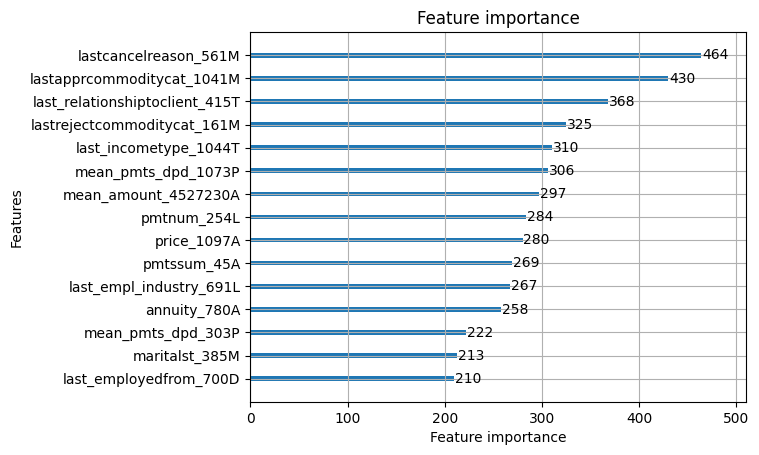

In [18]:
lgb.plot_importance(stadart_lgbt, max_num_features=15)

In [33]:
pd.options.display.max_colwidth = 200
very_important_cols = ['lastcancelreason_561M',
                       'lastapprcommoditycat_1041M',
                       'pmts_dpd_1073P',
                       'price_1097A',
                       'incometype_1044T',
                       'relationshiptoclient_415T',
                       'lastrejectcommoditycat_161M',
                       'amount_4527230A',
                       'pmtnum_254L',
                       'empl_industry_691L',
                       'annuity_780A',
                       'pmtssum_45A',
                       'sex_738L',
                       'pmts_overdue_1140A',
                       'pmts_dpd_303P']
# Чуть чуть манипуляций, чтобы колонки были в нужном порядке
feature_definition[feature_definition['Variable'].isin(very_important_cols)]
elements_df = pd.DataFrame(very_important_cols, columns=['Variable'])
result = elements_df.merge(feature_definition, on='Variable')
result

,Variable,Description
0,lastcancelreason_561M,Cancellation reason of the last application.
1,lastapprcommoditycat_1041M,Commodity category of the last loan applications made by the applicant.
2,pmts_dpd_1073P,"Days past due of the payment for the active contract (num_group1 - existing contract, num_group2 - payment)."
3,price_1097A,Credit price.
4,incometype_1044T,Type of income of the person
5,relationshiptoclient_415T,Relationship to the client.
6,lastrejectcommoditycat_161M,Category of commodity in the applicant's last rejected application.
7,amount_4527230A,Tax deductions amount tracked by the government registry.
8,pmtnum_254L,Total number of loan payments made by the client.
9,empl_industry_691L,Employment Industry of the person.


Самые важные показатели для моей модели \
`lastcancelreason_561M` - Причина отмены последней заявки. \
`lastapprcommoditycat_1041M` - Товарная категория последней заявки на получение кредита, поданной заявителем. \
`pmts_dpd_1073P` - Дней просрочки платежа по действующему контракту \
`price_1097A` - Цена кредита \
`incometype_1044T` - тип дохода клиента \
`relationshiptoclient_415T` - Отношение к клиенту. \
`lastrejectcommoditycat_161M` - Категория товара в последней отклоненной заявке заявителя. \
`amount_4527230A` - Сумма налоговых вычетов отслеживается в государственном реестре. \
`pmtnum_254L`	- Общее количество платежей по кредиту, произведенных клиентом. \
`empl_industry_691L` - Сфера занятости человека. \
`annuity_780A` - Сумма ежемесячной ренты. \
`pmtssum_45A`	- Сумма налоговых вычетов для клиента. \
`sex_738L` - пол клиента \
`pmts_overdue_1140A` - Просроченный платеж по действующему контракту \
`pmts_dpd_303P` - По данным кредитного бюро, платеж по расторгнутому договору просрочен на несколько дней \

Я это всё расписал, чтобы было легче понимать физику процессов, в каких единицах всё измеряется. Теперь идёт лютый feature_engineering

In [19]:
my_very_important_cols = ['target', 'lastcancelreason_561M', 'lastapprcommoditycat_1041M', 'mean_pmts_dpd_1073P', 'price_1097A',
                       'last_incometype_1044T', 'last_relationshiptoclient_415T', 'lastrejectcommoditycat_161M',
                       'mean_amount_4527230A', 'pmtnum_254L', 'last_empl_industry_691L', 'annuity_780A',
                       'pmtssum_45A', 'last_sex_738L', 'mean_pmts_overdue_1140A', 'mean_pmts_dpd_303P']

In [20]:
df_train[my_very_important_cols]

,target,lastcancelreason_561M,lastapprcommoditycat_1041M,mean_pmts_dpd_1073P,price_1097A,last_incometype_1044T,last_relationshiptoclient_415T,lastrejectcommoditycat_161M,mean_amount_4527230A,pmtnum_254L,last_empl_industry_691L,annuity_780A,pmtssum_45A,last_sex_738L,mean_pmts_overdue_1140A,mean_pmts_dpd_303P
0,0,a55475b1,a55475b1,NaN,NaN,SALARIED_GOVT,COLLEAGUE,a55475b1,NaN,24.0,OTHER,1917.599976,NaN,F,NaN,NaN
1,0,a55475b1,a55475b1,NaN,NaN,SALARIED_GOVT,OTHER_RELATIVE,a55475b1,NaN,18.0,OTHER,3134.000000,NaN,M,NaN,NaN
2,0,a55475b1,a55475b1,NaN,NaN,EMPLOYED,SPOUSE,a55475b1,NaN,36.0,OTHER,4937.000000,NaN,F,NaN,NaN
3,0,P94_109_143,a55475b1,NaN,NaN,EMPLOYED,SPOUSE,a55475b1,NaN,12.0,OTHER,4643.600098,NaN,F,NaN,NaN
4,1,P24_27_36,a55475b1,NaN,NaN,EMPLOYED,SIBLING,a55475b1,NaN,24.0,OTHER,3390.199951,NaN,F,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219144,0,a55475b1,a55475b1,0.125000,NaN,SALARIED_GOVT,NaN,a55475b1,1279.899902,12.0,NaN,2448.400146,NaN,F,29.475000,1.425000
1219145,0,a55475b1,a55475b1,0.043478,NaN,RETIRED_PENSIONER,NaN,a55475b1,NaN,36.0,NaN,3175.000000,NaN,F,0.138609,1.354962
1219146,0,a55475b1,a55475b1,0.000000,NaN,PRIVATE_SECTOR_EMPLOYEE,NaN,a55475b1,2400.699951,36.0,NaN,5983.399902,NaN,M,0.000000,1112.685669
1219147,0,a55475b1,a55475b1,0.000000,NaN,EMPLOYED,NaN,a55475b1,1003.266663,36.0,NaN,6596.000000,NaN,M,0.000000,1.531250


In [22]:
# Да, желательно бы побольше комбинаций составить, но я уже так спать хочу
def fe_df(df):
    df['price_1097A_mean_pmts_dpd_1073P'] = df['mean_pmts_dpd_1073P'] / (df['price_1097A'] + 1)
    df['annuity_780A_pmts_dpd_303P'] = df['annuity_780A'] * df['mean_pmts_dpd_303P']
    df['empl_industry_691L_lastcancelreason_561M'] = (df['lastcancelreason_561M'].astype(str)  + df['last_empl_industry_691L'].astype(str)).astype('category') 
    df['last_sex_738L_last_relationshiptoclient_415T'] = (df['last_relationshiptoclient_415T'].astype(str)  + df['last_sex_738L'].astype(str)).astype('category')
    df['mean_pmts_dpd_303P_mean_pmts_dpd_1073P'] = df['mean_pmts_dpd_303P'] / (df['mean_pmts_dpd_1073P'] + 1)
    df['triple'] = np.log((df['mean_pmts_dpd_1073P']*df['mean_amount_4527230A'] + df['pmtnum_254L']))
    df['sex_last_incometype_1044T'] = (df['last_incometype_1044T'].astype(str)  + df['last_sex_738L'].astype(str)).astype('category')

    return df

fe_df(df_train)
fe_df(df_test)

,case_id,WEEK_NUM,month_decision,weekday_decision,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,...,last_empls_employer_name_740M,count_num_group1_13,count_num_group2_13,price_1097A_mean_pmts_dpd_1073P,annuity_780A_pmts_dpd_303P,empl_industry_691L_lastcancelreason_561M,last_sex_738L_last_relationshiptoclient_415T,mean_pmts_dpd_303P_mean_pmts_dpd_1073P,triple,sex_last_incometype_1044T
0,46835,60,2,2,NaN,-10374.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,P94_109_143OTHER,OTHER_RELATIVEM,NaN,11.270497,EMPLOYEDM
1,47018,60,2,3,NaN,-22155.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,a55475b1nan,OTHER_RELATIVEF,NaN,NaN,RETIRED_PENSIONERF
2,47186,60,2,2,NaN,-9400.0,5.0,5.0,4.0,11.0,...,NaN,NaN,NaN,NaN,2.507144e+06,P24_27_36OTHER,FRIENDF,123.214287,5.988599,SALARIED_GOVTF
3,47190,60,2,2,NaN,-10557.0,1.0,1.0,1.0,4.0,...,NaN,NaN,NaN,NaN,1.397639e+07,a55475b1OTHER,FRIENDF,1347.875000,3.178054,EMPLOYEDF
4,47191,60,2,2,NaN,-10739.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,a55475b1GOVERNMENT,SIBLINGF,NaN,13.690351,SALARIED_GOVTF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307505,2703450,91,10,1,NaN,-22193.0,0.0,0.0,0.0,0.0,...,a55475b1,1.0,1.0,0.000000,2.901632e+03,a55475b1nan,nanF,0.789474,NaN,RETIRED_PENSIONERF
307506,2703451,91,10,1,NaN,-25541.0,0.0,0.0,0.0,0.0,...,a55475b1,1.0,1.0,NaN,0.000000e+00,a55475b1nan,nanF,0.000000,NaN,RETIRED_PENSIONERF
307507,2703452,91,10,1,NaN,-15771.0,2.0,2.0,0.0,3.0,...,a55475b1,1.0,1.0,0.444444,0.000000e+00,P180_60_137nan,nanM,0.000000,NaN,PRIVATE_SECTOR_EMPLOYEEM
307508,2703453,91,10,1,NaN,-25814.0,2.0,2.0,1.0,4.0,...,a55475b1,1.0,1.0,0.000000,4.277657e+02,a55475b1nan,nanF,0.357843,NaN,RETIRED_PENSIONERF


In [27]:
# Забыл закастить обратно в категории
df_train['empl_industry_691L_lastcancelreason_561M'] = df_train['empl_industry_691L_lastcancelreason_561M'].astype('category')
df_train['last_sex_738L_last_relationshiptoclient_415T'] = df_train['last_sex_738L_last_relationshiptoclient_415T'].astype('category')
df_test['empl_industry_691L_lastcancelreason_561M'] = df_test['empl_industry_691L_lastcancelreason_561M'].astype('category')
df_test['last_sex_738L_last_relationshiptoclient_415T'] = df_test['last_sex_738L_last_relationshiptoclient_415T'].astype('category')

## Модель 2

In [23]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 16,
    "learning_rate": 0.05,
    "n_estimators": 4000,
    "verbose": -1,
    "is_unbalance": True,
    "extra_trees": True,
}

X_train, X_val, y_train, y_val = train_test_split(df_train.drop('target', axis=1), df_train['target'],
                                                    test_size= 0.25, random_state=42)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

modify_lgbt = lgb.train(
    params,
    lgb_train,
    valid_sets=lgb_valid,
    callbacks=[lgb.log_evaluation(150), lgb.early_stopping(20)]
)

c:\Users\ya-2b\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[150]	valid_0's auc: 0.835974
[300]	valid_0's auc: 0.842016
[450]	valid_0's auc: 0.843449
[600]	valid_0's auc: 0.843811
Early stopping, best iteration is:
[619]	valid_0's auc: 0.843874


In [24]:
with mlflow.start_run(run_name=f'RUN new standart2', experiment_id=exp.experiment_id) as run:
    mlflow.log_param('shape of train dataset', df_train.shape)

    mlflow.log_params(modify_lgbt.params)
    mlflow.log_param('model_type', 'lgbt')

    mlflow.log_metric('roc auc score', modify_lgbt.best_score['valid_0']['auc'])
    mlflow.log_metric('num early stoping', modify_lgbt.best_iteration)

    mlflow.lightgbm.log_model(modify_lgbt, 'lgbm')

In [32]:
df_test['last_safeguarantyflag_411L'] = df_test['last_safeguarantyflag_411L'].astype('bool')
y_pred = modify_lgbt.predict(df_test)
sub4 = pd.DataFrame({
    'case_id' : df_test['case_id'],
    'score' : y_pred
})

sub4.to_csv('submit4_5.csv', index=False)

# Эксперимент №5